In [3]:
library(ape)
library(phytools)
library(phangorn)
library(phylosignal)
library(phylobase)
library(RPANDA)
library(phylolm)

source("NeTaGFT.R")

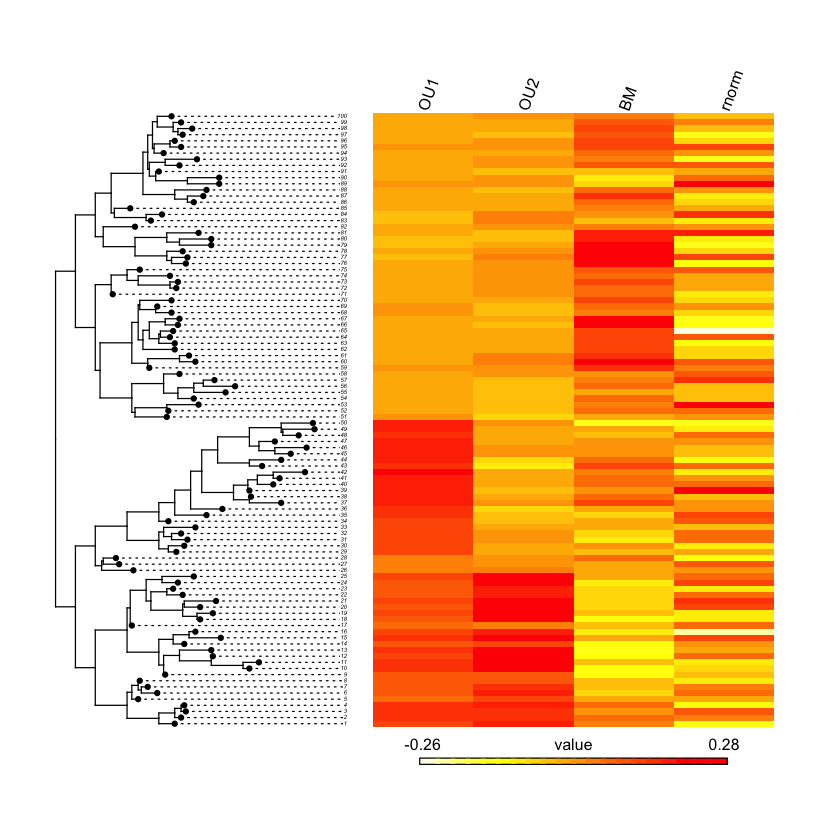

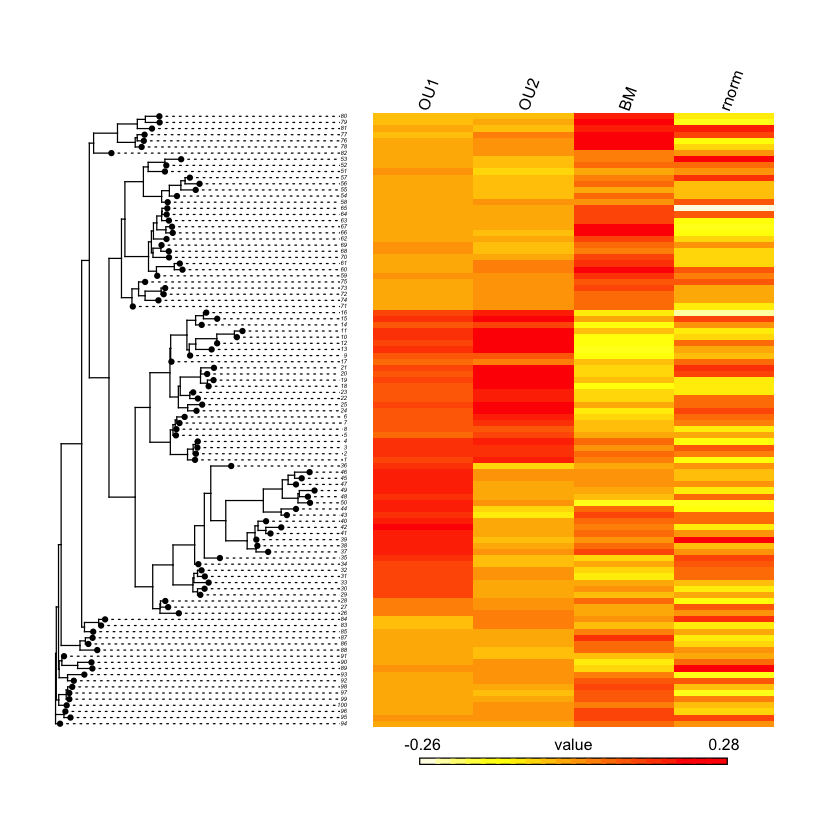

In [4]:
#create simulation traits
truetree <- read.tree("dataset_simulation/truetree.nwk")
truetree <- reorder(truetree, "postorder")

Nsub <- 25
N <- Nsub * 4

sigma <- 0.1

thetas1 <- rep(0,198)
for(i in 1:49){
    for(j in (i+1):50){
      a <- getMRCA(truetree,c(i,j))
      b <- which(truetree$edge[,1]==a)[1]
      c <- which(truetree$edge[,1]==a)[2]
      thetas1[b] <- 1
      thetas1[c] <- 1
    }
}

thetas2 <- rep(0,198)
for(i in 1:24){
    for(j in (i+1):25){
      a <- getMRCA(truetree,c(i,j))
      b <- which(truetree$edge[,1]==a)[1]
      c <- which(truetree$edge[,1]==a)[2]
      thetas2[b] <- 1
      thetas2[c] <- 1
    }
}

test1 <- rTraitCont(truetree, model = "OU", sigma = sigma, alpha = 1, theta = thetas1, ancestor = FALSE, root.value = 0)
test2 <- rTraitCont(truetree, model = "OU", sigma = sigma, alpha = 1, theta = thetas2, ancestor = FALSE, root.value = 0)
test3 <- rTraitCont(truetree, model = "BM", sigma = sigma, ancestor = FALSE, root.value = 0)
test4 <- rnorm(N)
X <- cbind(test1,test2,test3,test4)
for(i in 1:ncol(X)){
    X[,i] <- X[,i]/sqrt(sum(X[,i]**2))
}
colnames(X) <- c("OU1","OU2","BM","rnorm")


#truetree with fasttree
rownames(X) <- as.character(truetree$tip.label)
phylo.heatmap(truetree, X, fsize=c(0.3,0.8,0.8))

#reconstructed tree with fasttree
fasttree <- fasttree <- read.tree("dataset_simulation/fasttree.nwk")
rownames(X) <- as.character(truetree$tip.label)
phylo.heatmap(fasttree, X, fsize=c(0.3,0.8,0.8))

#normalization
for(i in 1:dim(X)[2]){
  X[,i] <- X[,i]/sqrt(sum(X[,i]**2))
}

In [5]:
#phylosignal(Cmeans)
fasttree$node.label <- 1:fasttree$Nnode + max(as.numeric(fasttree$tip.label))
p4d <- phylo4d(fasttree, X)
tmp <- phyloSignal(p4d = p4d, method = "all")
Cmeans <- tmp$stat$Cmean
names(Cmeans) <- colnames(X)
print(Cmeans)

         OU1          OU2           BM        rnorm 
 0.826162867  0.712966380  0.544547311 -0.001846162 


In [6]:
#mBIC based on the potimized OU model
scores <- rep(0,ncol(X))
for(i in 1:ncol(X)){
  tmp <- OUshifts(X[fasttree$tip.label,i], fasttree, nmax=1, method="mbic")
  scores[i] <- tmp$score
}
names(scores) <- colnames(X)
print(scores)

      OU1       OU2        BM     rnorm 
-547.1241 -408.0750 -302.2621 -165.2498 


In [7]:
#spectR_t(fragmenter)
fragmenters <- rep(0, ncol(X))
for(i in 1:ncol(X)){
  tmp <- spectR_t(fasttree, X[fasttree$tip.label,i], draw=F)
  fragmenters[i] <- tmp$fragmenter
}
names(fragmenters) <- colnames(X)
print(fragmenters)

     OU1      OU2       BM    rnorm 
9.395495 8.658644 6.767792 5.052736 


      OU1       OU2        BM     rnorm 
0.1881532 0.2814178 0.5108162 0.9605488 


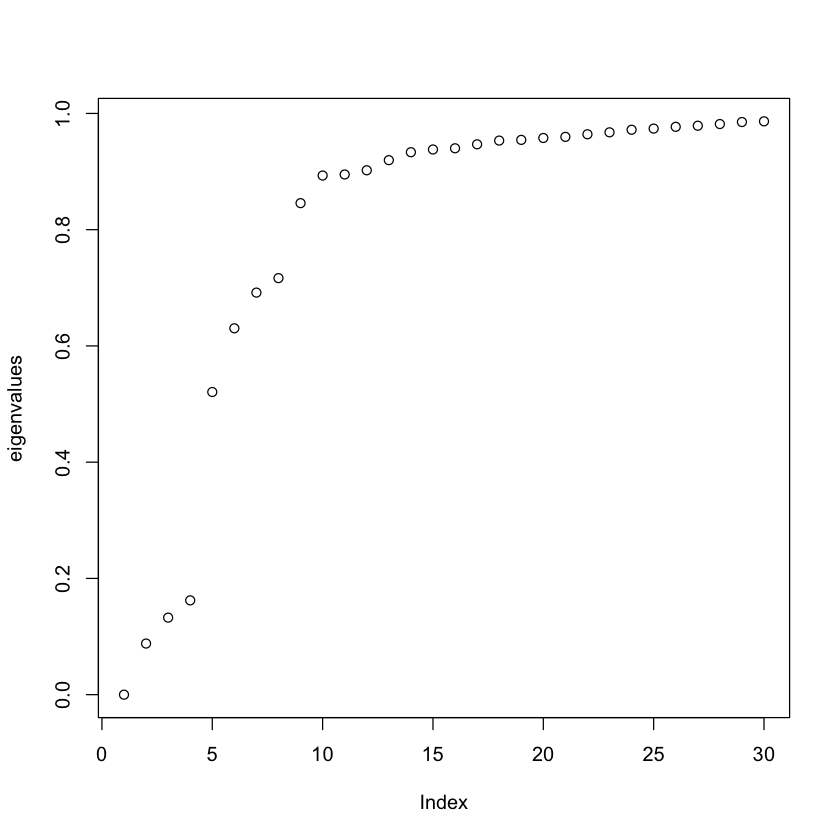

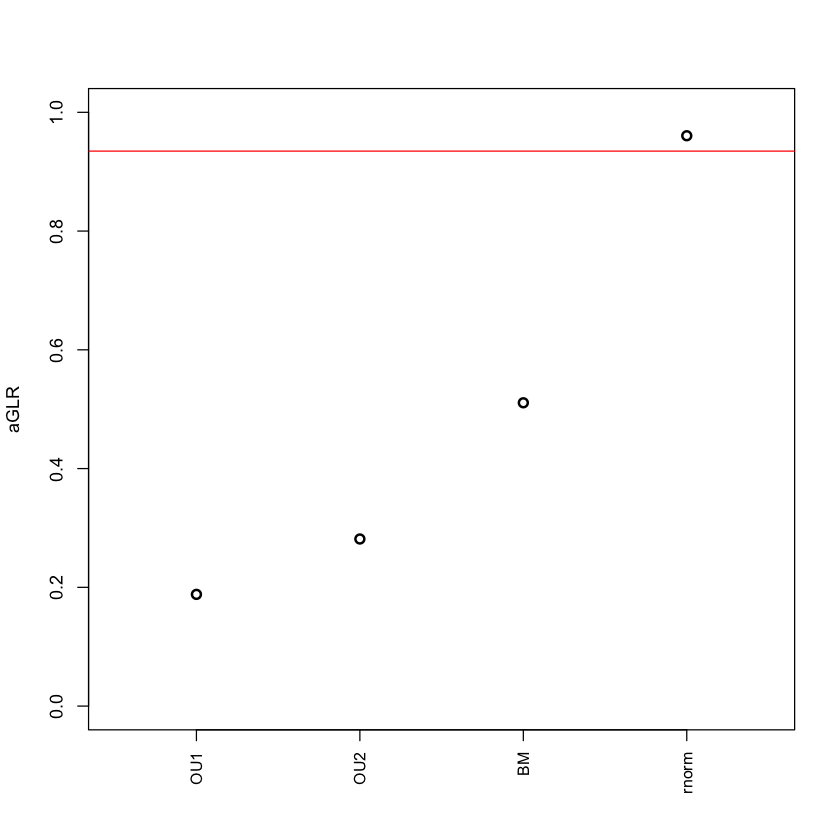

In [8]:
#aGLR
fin <- "dataset_simulation/KNN.txt"
A <- as.matrix(read.table(fin))
diag(A) <- 1
L <- sym_normalized_graph_laplacian(A)
tmp <- graph_fourier_transform(L,X,30)
U <- tmp$U
eigenvalues <- tmp$eigenvalues
hF <- tmp$hF
tF <- tmp$tF

aGLRs <- rep(0,ncol(X))
names(aGLRs) <- colnames(X)
for(i in 1:ncol(X)){
  aGLRs[i] <- graph_laplacian_regularizer(X[,i], U, eigenvalues)
}
print(aGLRs)

plot(eigenvalues)
plot_aGLR(X, U, 100)

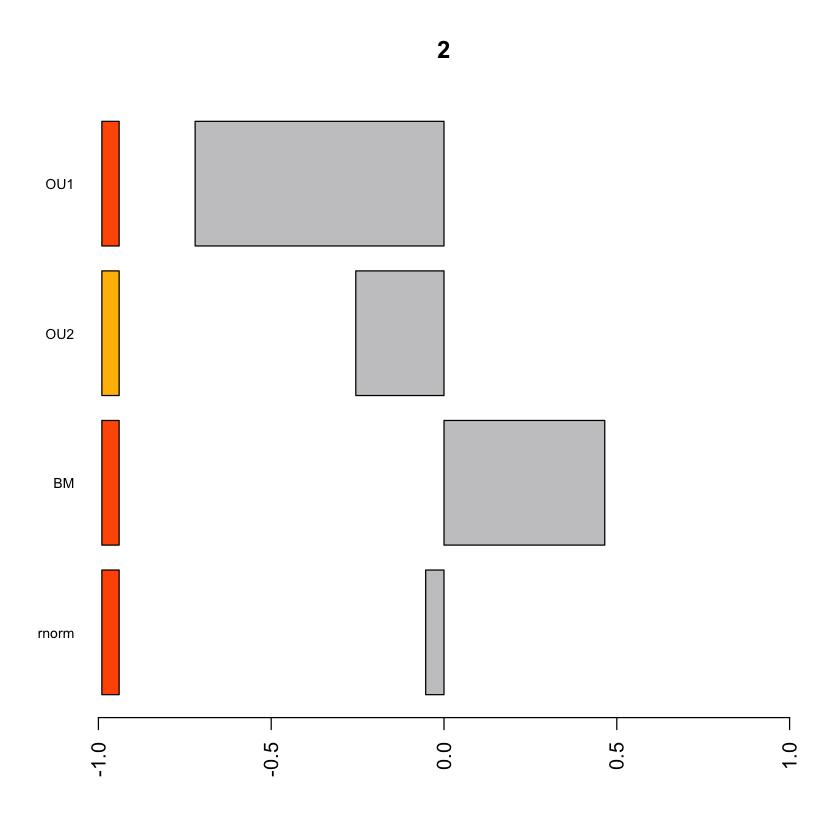

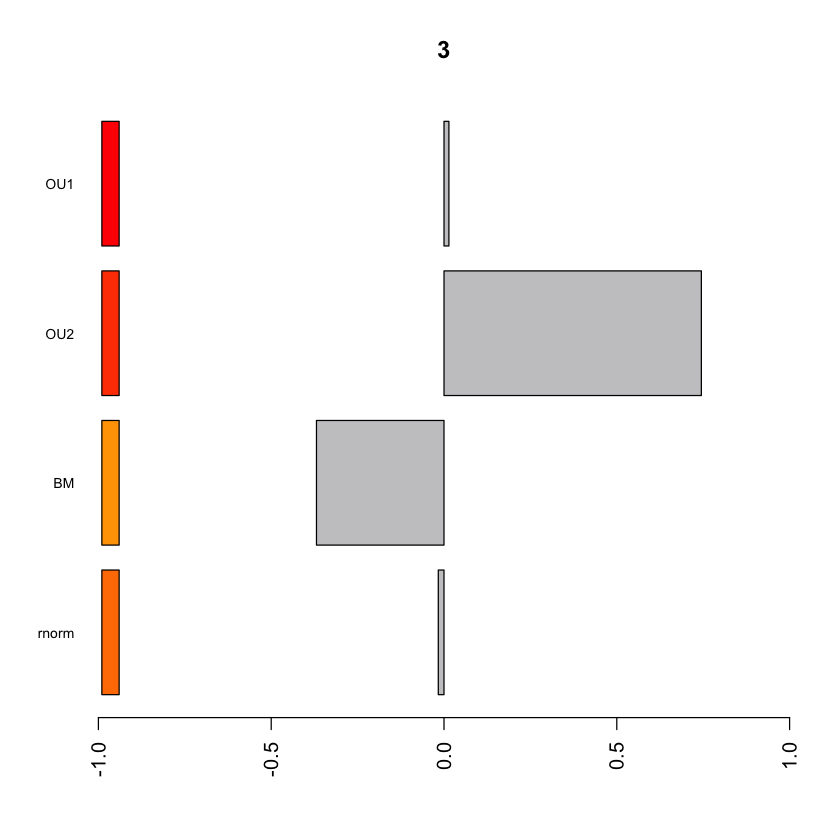

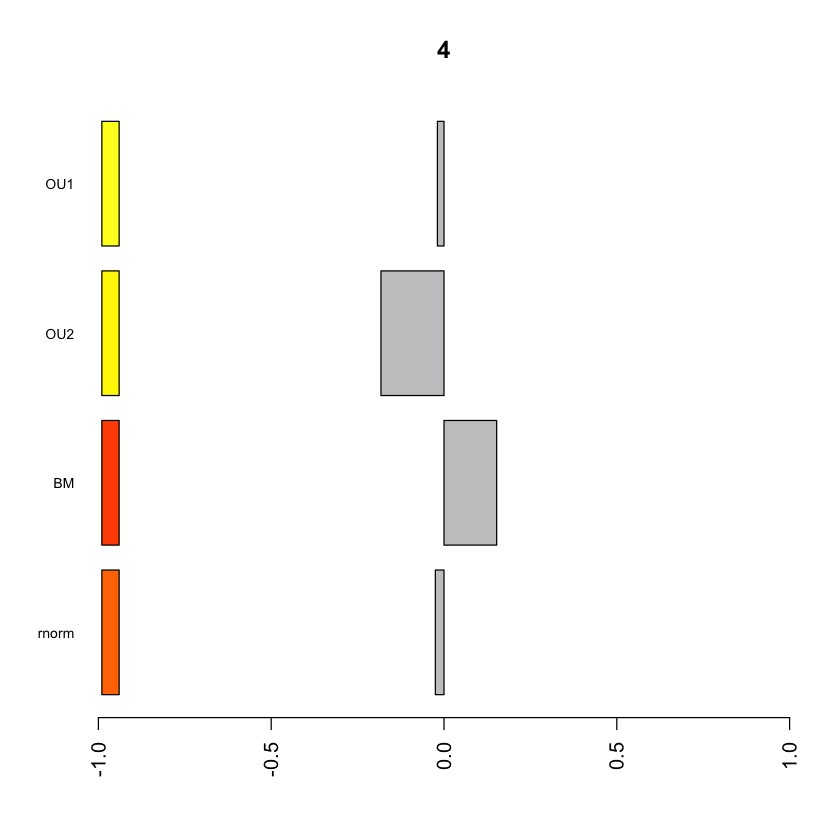

In [9]:
barplot_gfdomain(hF,tF,2)
barplot_gfdomain(hF,tF,3)
barplot_gfdomain(hF,tF,4)